# Import library

In [1]:
# 기본 패키지
import os
import time
import numpy as np
import pandas as pd

# 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 군집화 패키지
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# 모델링 패키지
import eli5 
import sklearn
import matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from eli5.sklearn import PermutationImportance

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
# print('pycaret : %s'%(pycaret.__version__))
!python --version

Pandas : 1.4.3
Numpy : 1.23.1
Scikit-Learn : 1.1.2
seaborn : 0.11.2
matplotlib : 3.5.3
Python 3.9.12


# Load Data

In [2]:
# 데이터 불러오기
demo = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_01_DEMO.csv', low_memory=False)
pdde = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_02_PDDE.csv', low_memory=False)
cop = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_03_COP_U.csv', low_memory=False)
clac = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_04_PD_CLAC.csv', low_memory=False)
br = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_05_BR.csv', low_memory=False)
lpay = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_06_LPAY.csv', low_memory=False)
covid19 = pd.read_csv("../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/[한국] 대한민국의 코로나19 총 누적 확진자와 사망자 _ 일간 (2022년 8월 9일).csv", low_memory = False)

# 영어변수명을 한글로 열 이름 변경
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
pdde.columns = ['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '구매시간', '구매금액', '구매수량']
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '이용일자', '방문일자', '이용시간', '이용금액']
clac.columns = ['상품코드', '소분류명', '대분류명', '중분류명']
br.columns = ['점포코드', '제휴사', '점포대분류코드', '점포중분류코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '이용일자', '이용시간', '이용금액']

# Data Preprocessing

- 중복되는 행 제거  
    - 구매수량이라는 칼럼이 존재하는데도 불구하고 모든 정보가 일치하는 경우에 한해서 중복되는 행을 제거  
    - 데이터 추출 시, 고객과 상품을 각각 추출하여 중복된 데이터가 발생했다고 판단  
- 결측치 치환  
    - 데이터의 '채널구분'열을 참고하면 결측치가 있는 구매는 모두 온라인에서 구매한 것으로 확인할 수 있기 때문에 '온라인'이라는 텍스트로 대체  

####  [2. pdde]: 상품 구매 정보

In [3]:
# 중복되는 행 제거
pdde.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

# 결측치 치환
pdde['점포코드'] = pdde['점포코드'].fillna('온라인')

#### [3. cop]: 제휴사 이용 정보

In [4]:
# 결측치 치환
cop['점포코드'] = cop['점포코드'].fillna('온라인')

#### [외부데이터]: 일별 코로나 확진자 수

- 코로나 외부데이터 사용  
    - 출처: https://insfiler.com/detail/rt_corona19_all-0008  
    - 일부 칼럼 추출: 데이터 중에서 일자, 신규확진자, 신규사망자 칼럼만 사용  
    - 날짜 데이터를 날짜형식으로 데이터를 변환하고, 날짜 순으로 정렬

In [5]:
# 필요한 데이터만 추출
covid19 = covid19[['일자', '신규확진(명)', '신규사망(명)']]

# 열 이름 변경
covid19.columns = ['날짜', '신규확진자', '신규사망자']

# 날짜 형식으로 변환
covid19['날짜'] = covid19['날짜'].apply(lambda x: x.replace('/', '-')).astype(str)
covid19['날짜'] = pd.to_datetime(covid19['날짜'])

# 날짜 순으로 데이터 정렬
covid19 = covid19.sort_values(by = '날짜')
covid19

,날짜,신규확진자,신규사망자
585,2021-01-01,824,25
584,2021-01-02,651,20
583,2021-01-03,1020,19
582,2021-01-04,715,26
581,2021-01-05,839,20
...,...,...,...
4,2022-08-05,110610,45
3,2022-08-06,105507,27
2,2022-08-07,55292,29
1,2022-08-08,149819,40


# Data Merge

- 모든 고객에 대하여 데이터를 관찰하기 위하여 타입을 구분하여 데이터를 통합  
- 다만 모든 데이터가 같은 정보를 가지고 있지 않기 때문에 새롭게 칼럼을 생성하여 데이터의 열을 통일

In [6]:
# 데이터를 통합하기 위하여 칼럼 통합
pdde['타입'] = 'Product'
cop['타입'] = 'Affiliate'
lpay['타입'] = 'Lpay'
pdde['방문일자'] = 0
lpay['방문일자'] = 0
cop['구매수량'] = 0
cop['상품코드'] = np.nan
lpay['점포코드'] = np.nan
lpay['상품코드'] = np.nan
lpay['구매수량'] = 0

In [7]:
# 칼럼명을 새롭게 동일하게 통일
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '구매일자', '방문일자', '구매시간', '구매금액', '타입', '구매수량', '상품코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '구매일자', '구매시간', '구매금액', '타입', '방문일자', '점포코드', '상품코드', '구매수량']

# 상품구매데이터를 기준으로 하여 열을 통일
cop = cop[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]
lpay = lpay[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]

# 데이터 타입 변경
lpay['영수증번호'] = lpay['영수증번호'].astype('object')
lpay['점포코드'] = lpay['점포코드'].astype('object')
cop['상품코드'] = cop['상품코드'].astype('object')
lpay['상품코드'] = lpay['상품코드'].astype('object')
pdde['구매금액'] = pdde['구매금액'].astype('int')
pdde['방문일자'] = pdde['방문일자'].astype('int64')
lpay['방문일자'] = lpay['방문일자'].astype('int64')

In [8]:
# 데이터 concat
df = pd.concat([pdde,cop,lpay])
# 고객 정보 테이븛 통합
df = pd.merge(df, demo, on = ['고객번호'], how = 'left')
# 상품 분류 테이블 통합
df = pd.merge(df, br, on = ['점포코드','제휴사'], how = 'left')
# 점포 정보 테이블 통합
df = pd.merge(df, clac, on = ['상품코드'], how = 'left')

In [9]:
# 결측치 확인 -> 데이터를 합치면서 생기는 결측치만 존재
df.isnull().sum()

고객번호             0
영수증번호            0
채널구분             0
제휴사              0
점포코드        353184
상품코드        601488
구매일자             0
구매시간             0
구매금액             0
구매수량             0
타입               0
방문일자             0
성별               0
연령대              0
거주지대분류코드         0
점포대분류코드     729023
점포중분류코드     729023
소분류명        601488
대분류명        601488
중분류명        601488
dtype: int64

## Train Test Split

- 구매건수가 3건이 넘어가는 고객을 대상으로 기존고객이라고 간주하고, 나머지 고객에 대해서는 신규고객으로 간주하여 기존고객으로 군집화를 진행하여 라벨을 만들고, 신규고객의 유형을 예측하는 과정을 진행하기 위하여 구매건수 3건을 기준으로 하여 신규고객과 기존고객으로 분할  
- 즉, 기존의 고객을 대상으로 학습을 진행한 뒤에 신규고객의 유형을 예측하기 위하여 학습과 테스트로 고객을 나누어서 진행

In [10]:
# 날짜로 변경
df['날짜'] = df['구매일자'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])
# 각 거래일간의 차이를 구함
df = df.sort_values(by=['날짜'], ascending=[True])
df['diff'] = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
df['diff'] = df['diff'].apply(lambda x: int(x.split()[0]))
# 데이터를 거래횟수별로 나누기 위한 작업
imp = df.groupby('고객번호')['영수증번호'].apply(set).reset_index()
imp['거래횟수'] = imp['영수증번호'].apply(lambda x:len(list(x)))
# 뉴비와 올드비를 구분해줌
oldbie = imp[imp['거래횟수']>3]['고객번호'].tolist()
newbie = imp[imp['거래횟수']<=3]['고객번호'].tolist()

# 데이터 분리
df_old = df[df['고객번호'].isin(oldbie)]
df_new = df[df['고객번호'].isin(newbie)]

# RFM

- 사용자별로 얼마나 최근에, 얼마나 자주, 얼마나 많은 금액을 지출했는지에 따라 사용자들의 분포를 확인하거나 사용자 그룹을 나누어 분류하는 분석기법인 RFM을 이용하여 고객 클러스터링을 진행  
    - R(Recency): 거래최근성을 말하며, 얼마나 최근에 구입했는가?
        - 데이터 셋의 시작시점을 기준으로 가장 최근 구매한 날짜까지의 일수 간격을 구함
        - 즉, 가장 최근에 방문한 고객이 가장 높은 점수를 가짐  
    - F(Frequency): 거래빈도를 말하며, 얼마나 빈번하게 우리 상품을 구입했는가?
        - 즉, 가장 많은 영수증 기록을 가진(가장 많이 방문한) 고객이 가장 높은 점수를 가짐  
    - M(Monetary): 거래규모를 말하며, 구입했던 총 금액은 어느 정도인가?  
        - 즉, 가장 많은 총 구매금액을 가진 고객이 가장 높은 점수를 가지게 됨

In [11]:
# 고객번호를 추출
customer_id = df_old.groupby('고객번호')[['구매일자']].max().index.tolist()
# Recency: 고객번호별로 구매일자의 최대값을 계산
recency = df_old.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
# Frequency: 고객별로 영수증번호의 갯수를 계산
freq = df_old.groupby('고객번호')['영수증번호'].apply(set).reset_index()
frequency = freq['영수증번호'].apply(lambda x:len(list(x)))
# Monetary: 고객별로 구매금액의 합계를 계산
monetary = df_old.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

# RFM을 이용한 데이터프레임을 생성
train_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})
test_rfm = pd.DataFrame({'고객번호': df_new.groupby('고객번호')[['구매일자']].max().index.tolist()})

In [12]:
# Recency의 경우 최근에 방문한 고객이 가장 높은 점수를 가져야하기 때문에 처음 날짜와의 차이를 계산
train_rfm['Recency'] = train_rfm['Recency'].astype(str)
train_rfm['Recency'] = pd.to_datetime(train_rfm['Recency'])
train_rfm['Recency'] = train_rfm['Recency'] - pd.to_datetime('20210101')
# train_rfm['Recency'] = [x.total_seconds() for x in train_rfm['Recency']]
# 날짜의 차이를 일수로 계산
train_rfm['Recency'] = train_rfm['Recency'].dt.days # days로
train_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240
1,M000136117,363,89,28697031
2,M000201112,331,5,51420
3,M000225114,364,88,2084270
4,M000261625,337,49,6072050
...,...,...,...,...
26207,M999673157,351,17,2851370
26208,M999770689,364,216,2078770
26209,M999849895,334,35,1095312
26210,M999926092,335,7,129500


# Data Clustering

- Kmeans Clustering을 진행하기 위하여 Scaling을 진행  
    - Scaling 기법으로 Standard Scaler를 사용

In [13]:
# Standard Scaler 적용
scaler = StandardScaler()
scaler.fit(train_rfm.iloc[:,1:])
rfm_scaled = scaler.transform(train_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = train_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', train_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.388787,-0.682454,-0.292294
1,M000136117,0.549046,0.211318,1.677066
2,M000201112,-0.183566,-0.776535,-0.331906
3,M000225114,0.571940,0.199558,-0.189339
4,M000261625,-0.046201,-0.259088,0.090332
...,...,...,...,...
26207,M999673157,0.274316,-0.635413,-0.135540
26208,M999770689,0.571940,1.704857,-0.189724
26209,M999849895,-0.114884,-0.423730,-0.258696
26210,M999926092,-0.091990,-0.753015,-0.326430


- Elbow Method를 이용한 최적의 군집 수 탐색  
    - 각 군집 간의 거리의 합인 intertia가 급격히 떨어지는 구간을 최적의 군집 수 K로 설정

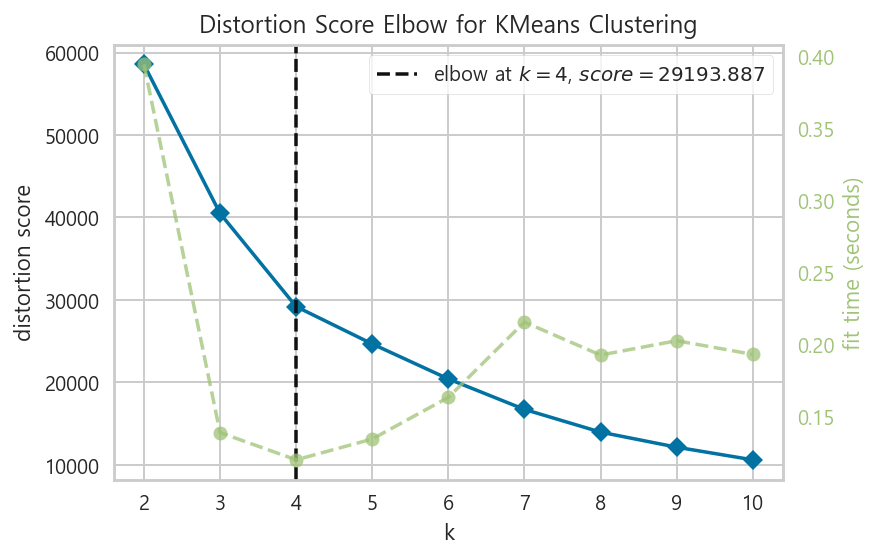

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Elbow Method를 이용한 최적의 군집 수 탐색
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

- 군집의 수를 4로 설정하여 각 고객별 유형을 라벨링

In [15]:
# 최적의 군집수를 4로 설정하여 클러스터링을 진행하여 고객별 군집을 라벨링하는 작업을 진행
kmeans = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))
labels = kmeans.fit_predict(rfm_scaled_df.iloc[:,1:])

In [17]:
# 각 고객의 유형을 기존 데이터와 통합하기 위하여 전처리하는 과정
rfm_scaled_df['labels'] = labels
train_rfm = rfm_scaled_df[['Customer_ID', 'labels']]
train_rfm.columns = ['고객번호', 'labels']
train_rfm.head(3)

,고객번호,labels
0,M000034966,0
1,M000136117,2
2,M000201112,0


- 기존의 통합한 데이터와 고객별 군집의 유형을 합치는 과정

In [18]:
# 클러스터링에 따른 고객별 군집의 유형을 합치는 작업
df_old = pd.merge(df_old, train_rfm, on = ['고객번호'], how = 'left')
# 코로나 외부데이터를 기존 데이터와 병합하는 과정
df_old = pd.merge(df_old, covid19, on = ['날짜'], how = 'left')
df_new = pd.merge(df_new, covid19, on = ['날짜'], how = 'left')
display(df_old.head(3))
display(df_new.head(3))

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,labels,신규확진자,신규사망자
0,M495972460,20122713C012328716,2,C01,C010004,NaN,20201227,13,26000,0,...,Z17,Z17011,NaN,NaN,NaN,2020-12-27,0,0,NaN,NaN
1,M039320884,20122911C011862577,2,C01,C010117,NaN,20201229,11,6500,0,...,Z06,Z06013,NaN,NaN,NaN,2020-12-29,0,2,NaN,NaN
2,M192531170,20122900C013317930,2,C01,C010026,NaN,20201229,0,10000,0,...,Z10,Z10011,NaN,NaN,NaN,2020-12-29,0,0,NaN,NaN


,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,신규확진자,신규사망자
0,M437975074,E02000030810,2,A02,온라인,PD1403,20210101,10,1194,3,...,Z12,NaN,NaN,당근,채소,뿌리채소,2021-01-01,0,824,25
1,M437975074,E02000030810,2,A02,온라인,PD1400,20210101,10,990,1,...,Z12,NaN,NaN,기타버섯류,채소,버섯류,2021-01-01,0,824,25
2,M437975074,E02000030810,2,A02,온라인,PD1511,20210101,10,12600,1,...,Z12,NaN,NaN,한우양지,축산물,국산소고기,2021-01-01,0,824,25


In [19]:
# 코로나 확진자수의 데이터가 2021년 부터 존재하기 때문에 2020년의 5일간의 데이터는 2021년 1월 1일의 데이터 값으로 대체
df_old['신규확진자'].fillna(824, inplace = True)
df_old['신규사망자'].fillna(25, inplace = True)
df_new['신규확진자'].fillna(824, inplace = True)
df_new['신규사망자'].fillna(25, inplace = True)

In [20]:
# 고객별로 고객의 정보를 합치는 과정
train_rfm = pd.merge(train_rfm, demo[demo['고객번호'].isin(oldbie)].reset_index(drop=True), how='inner',on='고객번호')
test_rfm = pd.merge(test_rfm, demo[demo['고객번호'].isin(newbie)].reset_index(drop=True), how='inner',on='고객번호')

In [21]:
# 열 순서 변경
train_rfm = train_rfm[['고객번호', '성별', '연령대', '거주지대분류코드', 'labels']]

## 파생변수 생성

- 영수증 번호의 길이

In [22]:
# 영수증 번호의 길이가 12, 15, 18 3가지로 나누어지는데 이는 각 다른 점포에서 결제한 것을 의미할 것이라고 판단하여 새로운 파생변수로 생성
df_old['영수증번호길이'] = df_old['영수증번호'].apply(lambda x: len(str(x)))
df_new['영수증번호길이'] = df_new['영수증번호'].apply(lambda x: len(str(x)))
df_old['영수증번호길이'].value_counts()

12    4134942
15     353002
18     245778
Name: 영수증번호길이, dtype: int64

In [23]:
# 각 고객별로 구매한 영수증에 대하여 평균, 최대를 통하여 고객이 가장 많이 구매하는 정보 등을 유추할 수 있을 것이라고 판단
train_rfm['영수증번호길이평균'] = df_old.groupby('고객번호')[['영수증번호길이']].mean()['영수증번호길이'].tolist()
train_rfm['영수증번호길이최대'] = df_old.groupby('고객번호')['영수증번호길이'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['영수증번호길이평균'] = df_new.groupby('고객번호')[['영수증번호길이']].mean()['영수증번호길이'].tolist()
test_rfm['영수증번호길이최대'] = df_new.groupby('고객번호')['영수증번호길이'].agg(lambda x:x.value_counts().index[0]).tolist()

- 영수증의 타입

In [24]:
# 영수증 번호의 타입을 생성하는 함수
def receipt_type(x):
    if len(str(x)) == 18:
        return str(x)[8]
    elif len(str(x)) == 15:
        return 'number'
    elif len(str(x)) == 12:
        return str(x)[0]

In [25]:
# 영수증마다 하나의 영어를 포함하거나, 모두 숫자로 이루어져있기 때문에 이러한 타입을 나타내는 파생변수를 생성
df_old['영수증타입'] = df_old['영수증번호'].apply(receipt_type)
df_new['영수증타입'] = df_new['영수증번호'].apply(receipt_type)
df_old['영수증타입'].value_counts()

A         3760036
E          381115
number     353002
D          154419
C           77108
B            8042
Name: 영수증타입, dtype: int64

In [26]:
# 각 고객별로 영수증 타입의 최대값을 계산하여 고객별로 주로 구매하는 정보를 유추할 수 있을 것이라고 판단
train_rfm['영수증타입최대값'] = df_old.groupby('고객번호')['영수증타입'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['영수증타입최대값'] = df_new.groupby('고객번호')['영수증타입'].agg(lambda x:x.value_counts().index[0]).tolist()

- 최대 구매 경로

In [27]:
df_old['채널구분'].value_counts()

1    4122105
2     611617
Name: 채널구분, dtype: int64

In [28]:
# 구매경로를 온라인, 오프라인으로 구분하는 함수
def buy_root(x):
    if x == 1:
        return '오프라인'
    elif x == 2:
        return '온라인'

In [29]:
# 고객별로 가장 많이 구매한 경로를 통하여 고객의 주요 구매 경로를 찾을 수 있음
train_rfm['최다구매경로'] = df_old.groupby('고객번호')['채널구분'].agg(lambda x:x.value_counts().index[0]).tolist()
train_rfm['최다구매경로'] = train_rfm['최다구매경로'].apply(buy_root)
test_rfm['최다구매경로'] = df_new.groupby('고객번호')['채널구분'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['최다구매경로'] = test_rfm['최다구매경로'].apply(buy_root)

- 제휴사의 타입

In [30]:
# 제휴사의 제일 앞에 알파벳의 경우에는 제휴사의 타입을 나타낼 수 있기 때문에 파생변수로 생성
df_old['제휴사타입'] = df_old['제휴사'].apply(lambda x: str(x)[0])
df_new['제휴사타입'] = df_new['제휴사'].apply(lambda x: str(x)[0])
df_old['제휴사타입'].value_counts()

A    4362804
D     171769
L      93429
C      90236
B       8811
E       6673
Name: 제휴사타입, dtype: int64

In [31]:
# 기존에 나누어져 있는 제휴사 카테고리를 조금 더 큰 관점으로 분류
train_rfm['최다제휴사타입'] = df_old.groupby('고객번호')['제휴사타입'].agg(lambda x:x.value_counts().index[0]).tolist()
train_rfm['최다제휴사'] = df_old.groupby('고객번호')['제휴사'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['최다제휴사타입'] = df_new.groupby('고객번호')['제휴사타입'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['최다제휴사'] = df_new.groupby('고객번호')['제휴사'].agg(lambda x:x.value_counts().index[0]).tolist()

- 구매일자관련 파생변수

In [32]:
# 구매일자를 연, 월, 일, 요일로 분할하는 과정
df_old['구매일자'] = pd.to_datetime(df_old['구매일자'].astype(str))
df_old['구매년도'] = df_old['구매일자'].dt.year
df_old['구매월'] = df_old['구매일자'].dt.month
df_old['구매일'] = df_old['구매일자'].dt.day
df_old['구매요일'] = df_old['구매일자'].dt.weekday
df_new['구매일자'] = pd.to_datetime(df_new['구매일자'].astype(str))
df_new['구매년도'] = df_new['구매일자'].dt.year
df_new['구매월'] = df_new['구매일자'].dt.month
df_new['구매일'] = df_new['구매일자'].dt.day
df_new['구매요일'] = df_new['구매일자'].dt.weekday

- 구매년도

In [33]:
# 고객별로 가장 많이 구매했던 년도를 찾기 위함, 2020년이 나타나는 고객의 경우에는 이탈고객일 가능성이 높음
train_rfm['최다구매년도'] = df_old.groupby('고객번호')['구매년도'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['최다구매년도'] = df_new.groupby('고객번호')['구매년도'].agg(lambda x:x.value_counts().index[0]).tolist()

- 구매월

In [34]:
# 고객별로 가장 많이 구매한 월과 평균 구매월을 구하기 위함
train_rfm['평균구매월'] = df_old.groupby('고객번호')[['구매월']].mean()['구매월'].tolist()
train_rfm['최다구매월'] = df_old.groupby('고객번호')['구매월'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['평균구매월'] = df_new.groupby('고객번호')[['구매월']].mean()['구매월'].tolist()
test_rfm['최다구매월'] = df_new.groupby('고객번호')['구매월'].agg(lambda x:x.value_counts().index[0]).tolist()

In [35]:
# 최다 구매 계절의 파생변수를 만들기 위해 계절을 나누는 파생변수 생성
def season(x):
    if x >= 3 and x <= 5:
        return '봄'
    elif x >= 6 and x <= 7:
        return '여름'
    elif x >= 8 and x <= 11:
        return '가을'
    else:
        return '겨울'

In [36]:
# 고객별로 가장 많이 구매하는 계절을 구하기 위함
df_old['구매계절'] = df_old['구매월'].apply(season)
train_rfm['최다구매계절'] = df_old.groupby('고객번호')['구매계절'].agg(lambda x:x.value_counts().index[0]).tolist()
df_new['구매계절'] = df_new['구매월'].apply(season)
test_rfm['최다구매계절'] = df_new.groupby('고객번호')['구매계절'].agg(lambda x:x.value_counts().index[0]).tolist()

In [37]:
# 고객별로 평균 구매하는 일자를 구하기 위함
train_rfm['평균구매일'] = df_old.groupby('고객번호')[['구매일']].mean()['구매일'].tolist()
test_rfm['평균구매일'] = df_new.groupby('고객번호')[['구매일']].mean()['구매일'].tolist()

In [38]:
# 요일을 만드는 파생변수 생성
def dayofweek(x):
    if x == 0:
        return '월요일'
    elif x == 1:
        return '화요일'
    elif x == 2:
        return '수요일'
    elif x == 3:
        return '목요일'
    elif x == 4:
        return '금요일'
    elif x == 5:
        return '토요일'
    elif x == 6:
        return '일요일'

In [39]:
# 고객별로 구매를 가장 많이 하는 요일을 구하기 위함
df_old['구매요일'] = df_old['구매요일'].apply(dayofweek)
train_rfm['구매요일최대값'] = df_old.groupby('고객번호')[['구매요일']].max()['구매요일'].tolist()
train_rfm['최다구매요일'] = df_old.groupby('고객번호')['구매요일'].agg(lambda x:x.value_counts().index[0]).tolist()
df_new['구매요일'] = df_new['구매요일'].apply(dayofweek)
test_rfm['구매요일최대값'] = df_new.groupby('고객번호')[['구매요일']].max()['구매요일'].tolist()
test_rfm['최다구매요일'] = df_new.groupby('고객번호')['구매요일'].agg(lambda x:x.value_counts().index[0]).tolist()

In [40]:
# 주중과 주말을 구분하는 함수 생성
def weekday(x):
    if x == '토요일' or x == '일요일':
        return '주말'
    else:
        return '주중'

In [41]:
# 고객별로 주중과 주말 중 선호하는 타입을 찾기 위함
df_old['주중주말여부'] = df_old['구매요일'].apply(weekday)
train_rfm['주중주말선호도'] = df_old.groupby('고객번호')['주중주말여부'].agg(lambda x:x.value_counts().index[0]).tolist()
df_new['주중주말여부'] = df_new['구매요일'].apply(weekday)
test_rfm['주중주말선호도'] = df_new.groupby('고객번호')['주중주말여부'].agg(lambda x:x.value_counts().index[0]).tolist()

- 구매시간 관련 파생변수

In [42]:
# 고객별로 평균적으로 구매하는 시간과 가장 많이 구매하는 시간을 찾기 위함
train_rfm['평균구매시간'] = df_old.groupby('고객번호')[['구매시간']].mean()['구매시간'].tolist()
train_rfm['최다구매시간'] = df_old.groupby('고객번호')['구매시간'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['평균구매시간'] = df_new.groupby('고객번호')[['구매시간']].mean()['구매시간'].tolist()
test_rfm['최다구매시간'] = df_new.groupby('고객번호')['구매시간'].agg(lambda x:x.value_counts().index[0]).tolist()

In [43]:
# 시간을 새벽, 오전, 오후, 저녁으로 분할하는 함수
def hour_type(x):
    if x < 6:
        return '새벽'
    elif x >= 6 and x < 12:
        return '오전'
    elif x < 18 and x >= 12:
        return '오후'
    else:
        return '저녁'

In [44]:
# 고객별로 주로 구매하는 시간을 타입으로 나누는 과정
df_old['구매시간분류'] = df_old['구매시간'].apply(hour_type)
train_rfm['주구매시간분류'] = df_old.groupby('고객번호')['구매시간분류'].agg(lambda x:x.value_counts().index[0]).tolist()
df_new['구매시간분류'] = df_new['구매시간'].apply(hour_type)
test_rfm['주구매시간분류'] = df_new.groupby('고객번호')['구매시간분류'].agg(lambda x:x.value_counts().index[0]).tolist()

- 구매금액 관련 파생변수

In [45]:
# 고객별로 평균, 최대, 최소 구매금액을 구하는 과정
train_rfm['평균구매금액'] = df_old.groupby('고객번호')[['구매금액']].mean()['구매금액'].tolist()
train_rfm['최대구매금액'] = df_old.groupby('고객번호')['구매금액'].agg(lambda x:x.value_counts().index[0]).tolist()
train_rfm['최소구매금액'] = df_old.groupby('고객번호')[['구매금액']].min()['구매금액'].tolist()
test_rfm['평균구매금액'] = df_new.groupby('고객번호')[['구매금액']].mean()['구매금액'].tolist()
test_rfm['최대구매금액'] = df_new.groupby('고객번호')['구매금액'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['최소구매금액'] = df_new.groupby('고객번호')[['구매금액']].min()['구매금액'].tolist()

- 구매수량 관련 파생변수

In [46]:
# 고객별로 평균, 최대, 최소 구매수량 및 평균적으로 구매하는 상품 하나의 가격을 구함
train_rfm['평균구매수량'] = df_old.groupby('고객번호')[['구매수량']].mean()['구매수량'].tolist()
train_rfm['최대구매수량'] = df_old.groupby('고객번호')['구매수량'].agg(lambda x:x.value_counts().index[0]).tolist()
train_rfm['최소구매수량'] = df_old.groupby('고객번호')[['구매수량']].min()['구매수량'].tolist()
train_rfm['평균낱개구매금액'] = [(x/y) if y != 0 else 0 for x,y in zip(train_rfm['평균구매금액'], train_rfm['평균구매수량'])]
test_rfm['평균구매수량'] = df_new.groupby('고객번호')[['구매수량']].mean()['구매수량'].tolist()
test_rfm['최대구매수량'] = df_new.groupby('고객번호')['구매수량'].agg(lambda x:x.value_counts().index[0]).tolist()
test_rfm['최소구매수량'] = df_new.groupby('고객번호')[['구매수량']].min()['구매수량'].tolist()
test_rfm['평균낱개구매금액'] = [(x/y) if y != 0 else 0 for x,y in zip(test_rfm['평균구매금액'], test_rfm['평균구매수량'])]

- 주 이용채널

In [47]:
# 온라인만 이용하는 경우, 오프라인만 이용하는 경우, 둘다 이용하는 경우로 구분짓는 함수 생성
def div_ch(x):
    if set(x) == {1}: # 오프라인만 이용하는 경우
        return '오프라인'
    elif set(x) == {2}: # 온라인만 이용
        return '온라인'
    else: # 둘다이용
        return '둘다이용'

# 각 고객별로 이용하는 채널을 구하는 과정
train_rfm['이용채널'] = df_old.groupby('고객번호')['채널구분'].apply(list).reset_index()['채널구분'].apply(div_ch)
test_rfm['이용채널'] = df_new.groupby('고객번호')['채널구분'].apply(list).reset_index()['채널구분'].apply(div_ch)

- 엘페이 이용여부

In [48]:
# 각 고객별로 엘페이를 사용하는지 여부에 따라 나누는 과정
lpay_user_old = df_old[df_old['타입'] == 'Lpay']['고객번호'].unique()
train_rfm['Lpay이용여부'] = train_rfm['고객번호'].apply(lambda x:'Lpay사용' if x in lpay_user_old else 'Lpay미사용')
lpay_user_new = df_new[df_new['타입'] == 'Lpay']['고객번호'].unique()
test_rfm['Lpay이용여부'] = test_rfm['고객번호'].apply(lambda x:'Lpay사용' if x in lpay_user_new else 'Lpay미사용')

- 일별 코로나 확진자 및 사망자의 외부데이터를 이용하여 새로운 파생변수를 추가

In [49]:
# 고객이 구매하는 날짜의 평균적인 확진자, 사망자 수를 고려하는 파생변수를 생성
train_rfm['코로나신규확진자수평균'] = df_old.groupby('고객번호', as_index = False)['신규확진자'].mean()['신규확진자']
train_rfm['코로나신규사망자수평균'] = df_old.groupby('고객번호', as_index = False)['신규사망자'].mean()['신규사망자']
test_rfm['코로나신규확진자수평균'] = df_new.groupby('고객번호', as_index = False)['신규확진자'].mean()['신규확진자']
test_rfm['코로나신규사망자수평균'] = df_new.groupby('고객번호', as_index = False)['신규사망자'].mean()['신규사망자']

In [50]:
# train 데이터 확인
train_rfm.head(3)

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,...,최대구매금액,최소구매금액,평균구매수량,최대구매수량,최소구매수량,평균낱개구매금액,이용채널,Lpay이용여부,코로나신규확진자수평균,코로나신규사망자수평균
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,...,1980,100,1.224490,1,0,10270.666667,오프라인,Lpay미사용,2052.224490,14.612245
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,...,14300,100,0.884298,1,0,268196.551402,둘다이용,Lpay사용,1571.099174,15.553719
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,...,1700,20,1.450000,1,1,1773.103448,오프라인,Lpay미사용,1775.500000,6.650000


In [51]:
# test 데이터 확인
test_rfm.head(3)

,고객번호,성별,연령대,거주지대분류코드,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,...,최대구매금액,최소구매금액,평균구매수량,최대구매수량,최소구매수량,평균낱개구매금액,이용채널,Lpay이용여부,코로나신규확진자수평균,코로나신규사망자수평균
0,M000059535,여성,30대,Z12,18.0,18,C,온라인,C,C01,...,46000,46000,0.0,0,0,0.0,온라인,Lpay미사용,424.0,7.0
1,M000658311,여성,20대,Z16,12.0,12,A,오프라인,A,A01,...,7900,100,1.0,1,1,14450.0,오프라인,Lpay미사용,1324.0,5.0
2,M000713279,여성,50대,Z12,12.0,12,A,오프라인,A,A05,...,39000,39000,1.0,1,1,39000.0,오프라인,Lpay미사용,357.0,2.0


- 주구매 대분류, 중분류, 소분류

In [52]:
# 상품의 대분류, 중분류, 소분류에 대하여 결측치를 없음으로 채움
df_old['대분류명'].fillna('없음', inplace = True)
df_old['중분류명'].fillna('없음', inplace = True)
df_old['소분류명'].fillna('없음', inplace = True)
df_new['대분류명'].fillna('없음', inplace = True)
df_new['중분류명'].fillna('없음', inplace = True)
df_new['소분류명'].fillna('없음', inplace = True)

# Modeling

- train-test split

In [53]:
# X_train과 y_train으로 나누는 작업
target = train_rfm['labels']
data = train_rfm.drop(columns='labels')
x_test = test_rfm

# train_test_split (학습 데이터를 학습용과 검증용으로 나누는 과정)
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
# 인덱스를 지워줌
x_train, x_valid, y_train, y_valid = x_train.reset_index(drop=True), x_valid.reset_index(drop=True), y_train.reset_index(drop=True), y_valid.reset_index(drop=True)

- Preprocessing  
    - Standard Scaler: 수치형 변수의 경우 단위가 모두 다르기 때문에 정규분포 형태로 만들어주는 과정
    - Label Encoder: 범주형 변수의 경우 속도와 성능 측면에서 One-Hot Encoder보다 우수

In [54]:
# 범주형 변수와 수치형 변수를 분리하는 과정
## train
cat_feature_tr = x_train.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_tr = x_train.iloc[:,1:].select_dtypes(exclude='object').columns.to_list()
## test
cat_feature_val = x_valid.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_val = x_valid.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 
## test
cat_feature_te = x_test.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_te = x_test.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 

In [55]:
# Standard Scaler를 통하여 데이터를 정규분포 형태로 만들어줌
scaler = StandardScaler()
x_train[num_feature_tr] = scaler.fit_transform(x_train[num_feature_tr])
x_valid[num_feature_val] = scaler.transform(x_valid[num_feature_val])
x_test[num_feature_te] = scaler.transform(x_test[num_feature_te])

In [56]:
# Labelencoder를 진행
encoder = LabelEncoder()
encoded_cat_tr = []
encoded_cat_val = []
encoded_cat_te = []
for f in cat_feature_tr:
    encoder = encoder.fit(pd.concat([x_train, x_test]).reset_index(drop=True)[f])
    encoded_cat_tr.append(pd.DataFrame(encoder.transform(x_train[f]),columns = [f])) # train
    encoded_cat_val.append(pd.DataFrame(encoder.transform(x_valid[f]),columns = [f])) # valid
    encoded_cat_te.append(pd.DataFrame(encoder.transform(x_test[f]),columns = [f])) # test

# 라벨 인코딩한 뒤에 합쳐주는 과정
cat_tr = pd.concat(encoded_cat_tr, axis = 1) # train
cat_val = pd.concat(encoded_cat_val, axis = 1) # test
cat_te = pd.concat(encoded_cat_te, axis = 1) # test

In [57]:
# 범주형 변수와 수치형 변수를 다시 합쳐주는 과정
x_train_imp = pd.concat([x_train['고객번호'], cat_tr], axis=1)
x_valid_imp = pd.concat([x_valid['고객번호'], cat_val], axis=1)
x_test_imp = pd.concat([x_test['고객번호'], cat_te], axis=1)

x_train = pd.concat([x_train_imp, x_train[num_feature_tr]], axis=1)
x_valid = pd.concat([x_valid_imp, x_valid[num_feature_val]], axis=1)
x_test = pd.concat([x_test_imp, x_test[num_feature_te]], axis=1)

- catboost modeling  
    - cross-validation을 통하여 훈련데이터의 성능을 f1 score로 검증

In [58]:
# CatBoost 모델링을 통한 훈련데이터의 성능 평가
cat = CatBoostClassifier(random_state=42, verbose=0)

score = np.mean(cross_val_score(cat, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.6272595023024413

- catboost performance  
    - 검증용 데이터를 통하여 모델의 성능을 f1 score 및 accuracy로 평가

In [59]:
# CatBoost 모델링을 통한 검증데이터의 성능 평가
cat.fit(x_train.iloc[:,1:], y_train)
pred_cat = cat.predict(x_valid.iloc[:,1:])

print(f'f1_score: {f1_score(y_valid, pred_cat, average="macro")}')
print(f'acc_score: {accuracy_score(y_valid, pred_cat)}')

f1_score: 0.6161944861037384
acc_score: 0.8527560556933054


- catboost predict  
    - 학습시킨 모델을 바탕으로 신규고객의 유형을 예측

In [60]:
# 학습시킨 CatBoost 모델링을 통한 테스트데이터 예측
test_pred = cat.predict(x_test.iloc[:,1:])
cat_pred = pd.DataFrame({'고객번호': x_test.iloc[:,0], '예측유형': pd.DataFrame(test_pred)[0]})
cat_pred

,고객번호,예측유형
0,M000059535,1
1,M000658311,0
2,M000713279,1
3,M000859319,1
4,M001080017,1
...,...,...
3657,M998572907,1
3658,M999340261,1
3659,M999492154,0
3660,M999493501,1


- RandomForest modeling  
    - cross-validation을 통하여 훈련데이터의 성능을 f1 score로 검증

In [61]:
# RandomForest 모델링을 통한 훈련데이터의 성능 평가
rf = RandomForestClassifier(random_state=42)
score = np.mean(cross_val_score(rf, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.5575773074737178

- RandomForest inference  
    - 검증용 데이터를 통하여 모델의 성능을 f1 score 및 accuracy로 평가

In [62]:
# RandomForest 모델링을 통한 검증데이터의 성능 평가
rf.fit(x_train.iloc[:,1:], y_train)
pred_rf = rf.predict(x_valid.iloc[:,1:])

print(f'f1_score: {f1_score(y_valid, pred_rf, average="macro")}')
print(f'acc_score: {accuracy_score(y_valid, pred_rf)}')

f1_score: 0.6404725945752017
acc_score: 0.8483692542437535


- RandomForest predict  
    - 학습시킨 모델을 바탕으로 신규고객의 유형을 예측

In [63]:
# 학습시킨 RandomForest 모델링을 통한 테스트데이터 예측
test_pred = rf.predict(x_test.iloc[:,1:])
rf_pred = pd.DataFrame({'고객번호': x_test.iloc[:,0], '예측유형': pd.DataFrame(test_pred)[0]})
rf_pred

,고객번호,예측유형
0,M000059535,1
1,M000658311,0
2,M000713279,1
3,M000859319,1
4,M001080017,1
...,...,...
3657,M998572907,1
3658,M999340261,1
3659,M999492154,0
3660,M999493501,1


- LGBM modeling  
    - cross-validation을 통하여 훈련데이터의 성능을 f1 score로 검증

In [64]:
# LGBM 모델링을 통한 훈련데이터의 성능 평가
lgbm = LGBMClassifier(random_state=42)
score = np.mean(cross_val_score(lgbm, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.6651474309939744

- LGBM inference  
    - 검증용 데이터를 통하여 모델의 성능을 f1 score 및 accuracy로 평가

In [65]:
# LGBM 모델링을 통한 검증데이터의 성능 평가
lgbm.fit(x_train.iloc[:,1:], y_train)
pred_lgbm = lgbm.predict(x_valid.iloc[:,1:])

print(f'f1_score: {f1_score(y_valid, pred_lgbm, average="macro")}')
print(f'acc_score: {accuracy_score(y_valid, pred_lgbm)}')

f1_score: 0.7139765455021255
acc_score: 0.8556170131604044


- LGBM predict  
    - 학습시킨 모델을 바탕으로 신규고객의 유형을 예측

In [66]:
# 학습시킨 LGBM 모델링을 통한 테스트데이터 예측
test_pred = lgbm.predict(x_test.iloc[:,1:])
lgbm_pred = pd.DataFrame({'고객번호': x_test.iloc[:,0], '예측유형': pd.DataFrame(test_pred)[0]})
lgbm_pred

,고객번호,예측유형
0,M000059535,1
1,M000658311,0
2,M000713279,1
3,M000859319,1
4,M001080017,1
...,...,...
3657,M998572907,1
3658,M999340261,1
3659,M999492154,0
3660,M999493501,1


- 신규고객 잠재유형 예측 모델의 성능 비교  
    - CatBoost, RandomForest, LGBM의 성능을 비교  
    - 평가지표로는 F1 Score와 Accuracy를 사용

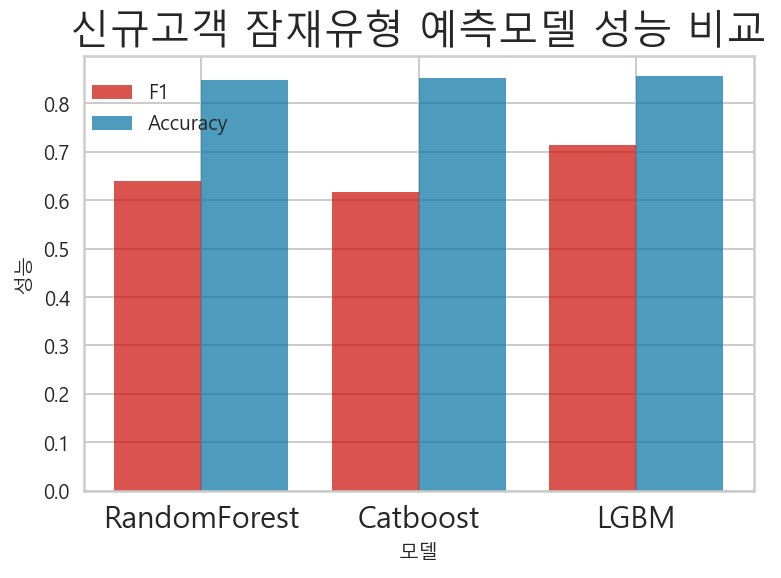

In [67]:
x = np.arange(3)

plt.bar(x-0.2, [f1_score(y_valid, pred_rf, average="macro"), f1_score(y_valid, pred_cat, average="macro"), f1_score(y_valid, pred_lgbm, average="macro")], 0.4, label='F1', color='r', alpha=0.7)
plt.bar(x+0.2, [accuracy_score(y_valid, pred_rf), accuracy_score(y_valid, pred_cat), accuracy_score(y_valid, pred_lgbm)], 0.4, label='Accuracy', color='b', alpha=0.7)

plt.title('신규고객 잠재유형 예측모델 성능 비교', fontsize=20)
plt.xticks(x, ['RandomForest', 'Catboost', 'LGBM'], fontsize = 15)
plt.ylabel('성능', fontsize=10)
plt.xlabel('모델', fontsize=10)
plt.legend( loc = (0,0.8))
plt.show()

- Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

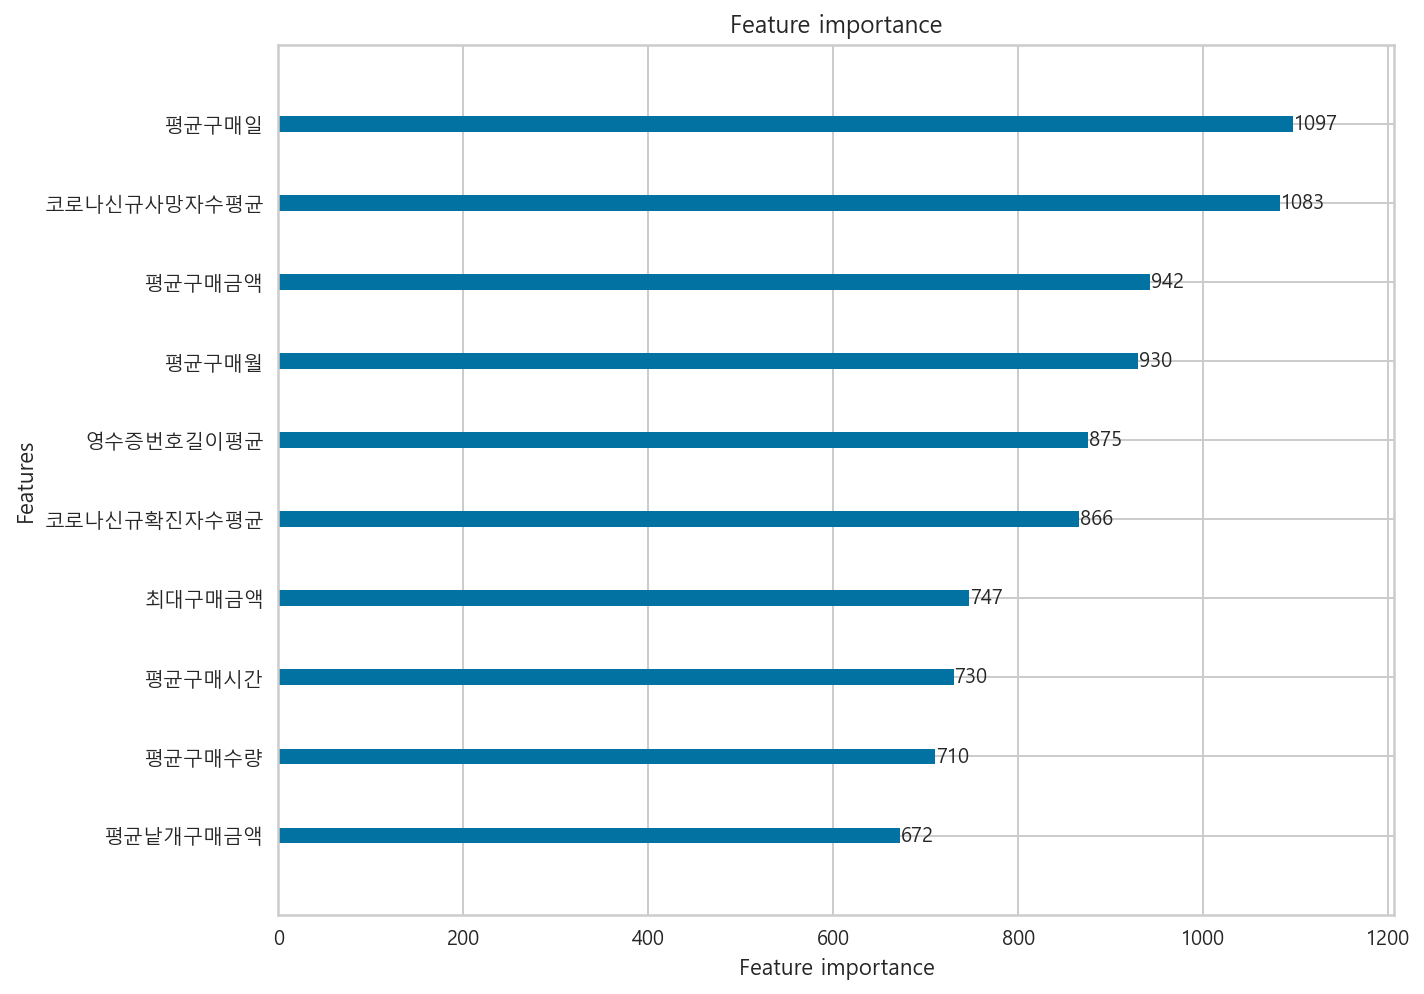

In [68]:
# LGBM 모델을 통한 Feature Importance 파악
plot_importance(lgbm, figsize=(10, 8), max_num_features=10)

- permutation importance
    - 위의 Feature importance 방식과 다르게 변수의 독립적인 중요도룰 판단하는 방식
    - 다른 변수와의 상호작용으로 인하여 변수의 중요도를 높게 판단하는 경우를 방지해줌 ( 독립 변수 자체의 변수 중요도룰 판단할 수 있음 )  
    - EDA를 통해 생성한 파생변수인 코로나 신규사망자수 평균, 평균 낱개구매 금액, LPay 이용여부 등이 포함된 것을 확인할 수 있음

In [69]:
# LGBM 모델의 permutation importance 파악
model = lgbm
perm = PermutationImportance(model, scoring = "f1_macro", random_state = 42).fit(x_train.iloc[:,1:], y_train) 
eli5.show_weights(perm,top=10, feature_names = x_train.iloc[:,1:].columns.tolist())

Weight,Feature
0.2715 ± 0.0069,평균구매금액
0.1957 ± 0.0060,코로나신규사망자수평균
0.1842 ± 0.0257,평균낱개구매금액
0.1609 ± 0.0275,최소구매금액
0.1118 ± 0.0025,평균구매월
0.0972 ± 0.0026,Lpay이용여부
0.0904 ± 0.0114,평균구매일
0.0842 ± 0.0037,코로나신규확진자수평균
0.0624 ± 0.0027,영수증번호길이평균
0.0527 ± 0.0148,구매요일최대값


# Customer Predict

In [70]:
df_predict = pd.merge(df[df['고객번호'].isin(lgbm_pred['고객번호'])], lgbm_pred, how = 'left', on = '고객번호')
df_predict = df_predict[['고객번호', '영수증번호', '채널구분', '제휴사', '구매일자', '구매시간', '구매금액', '성별', '연령대', '중분류명', '예측유형']]

In [71]:
# 유형 1 고객 추출 후 임의로 고객 1명 선택
df1 = df_predict[df_predict['예측유형']==1]
df1[df1['고객번호']=='M412637909'].iloc[:,:-1]

,고객번호,영수증번호,채널구분,제휴사,구매일자,구매시간,구매금액,성별,연령대,중분류명
7000,M412637909,A02199868530,1,A02,20210726,19,500,여성,20대,주방정리용품/소모품
7001,M412637909,A02199868530,1,A02,20210726,19,1380,여성,20대,냉장간편식
7002,M412637909,A02199868530,1,A02,20210726,19,1260,여성,20대,향신료
7003,M412637909,A02199868530,1,A02,20210726,19,6900,여성,20대,식용유류
7004,M412637909,A02199868530,1,A02,20210726,19,7900,여성,20대,닭고기류
7005,M412637909,A02199868530,1,A02,20210726,19,2560,여성,20대,양채류
8371,M412637909,A02200330732,1,A02,20210905,19,10000,여성,20대,파티/팬시용품
8372,M412637909,A02200330732,1,A02,20210905,19,3000,여성,20대,파티/팬시용품
10356,M412637909,A02201037459,1,A02,20211106,16,2000,여성,20대,파티/팬시용품


In [72]:
# 유형 2 고객 추출 후 임의로 고객 한명 선택
df2 = df_predict[df_predict['예측유형']==0]
df2[df2['고객번호']=='M808869026'].iloc[:,:-1]

,고객번호,영수증번호,채널구분,제휴사,구매일자,구매시간,구매금액,성별,연령대,중분류명
66,M808869026,E06000292337,2,A06,20210102,3,32000,여성,20대,메이크업
1154,M808869026,E06007798403,2,A06,20210203,22,40000,여성,20대,메이크업
10359,M808869026,A02228357399,1,A02,20211106,19,3720,여성,20대,탄산음료
10360,M808869026,A02228357399,1,A02,20211106,19,1320,여성,20대,청소용품
10361,M808869026,A02228357399,1,A02,20211106,19,1190,여성,20대,스낵류
10362,M808869026,A02228357399,1,A02,20211106,19,2580,여성,20대,수입과일
10363,M808869026,A02228357399,1,A02,20211106,19,19960,여성,20대,맥주
10364,M808869026,A02228357399,1,A02,20211106,19,2990,여성,20대,포장반찬
10365,M808869026,A02228357399,1,A02,20211106,19,12800,여성,20대,생선회
10366,M808869026,A02228357399,1,A02,20211106,19,4490,여성,20대,양채류


## END